In [1]:
import sys
sys.path.append("..")
from flame_analysis_model import *

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import umap
import torch
from mpi4py import MPI
import hdbscan
from sklearn.preprocessing import StandardScaler


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 4GB Laptop GPU


In [3]:
# 1) File path
timestep = 10
fname = f"./data/v6/po_premix0.f000{timestep}"
gname = "./data/v6/po_premix0.f00001"

# Communicator for parallelization
comm = MPI.COMM_WORLD

# 2) Load dataset
scalars = [
    'H2','O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'N2', 'heat_release',
    'curvature', 'stretch_rate', 'disp_speed_density_weighted',
    'abs_flame_prop_vel_normal', 'flow_velocity_normal',
    'flow_velocity_tangential', 'tangential_strain_rate',
    'normal_strain_rate', 'total_strain_rate', 'density_ratio_sigma',
    'vorticity'
]
ds = SEMDataset(fname, comm=MPI.COMM_WORLD, gname=gname, scalar_names=scalars)
df = ds.create_dataframe(
    compute_vel_jacobian= True,
    compute_vel_hessian= False,
    compute_reaction_rates= True,
    cantera_inputs = ["BurkeH2.yaml", None, 0.5, 300, 5e05]
)

2025-11-18 22:23:15,194 - Mesh - INFO - Initializing empty Mesh object.
2025-11-18 22:23:15,195 - Field - INFO - Initializing empty Field object
2025-11-18 22:23:15,195 - pynekread - INFO - Reading file: ./data/v6/po_premix0.f00001
2025-11-18 22:23:15,242 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-11-18 22:23:15,243 - Mesh - INFO - Initializing common attributes.
2025-11-18 22:23:15,244 - Mesh - INFO - Getting vertices
2025-11-18 22:23:15,250 - Mesh - INFO - Getting edge centers
2025-11-18 22:23:15,310 - Mesh - INFO - Facet centers not available for 2D
2025-11-18 22:23:15,311 - Mesh - INFO - Mesh object initialized.
2025-11-18 22:23:15,312 - Mesh - INFO - Mesh data is of type: float64
2025-11-18 22:23:15,312 - Mesh - INFO - Elapsed time: 0.06954739999491721s
2025-11-18 22:23:15,312 - pynekread - INFO - Reading field data
2025-11-18 22:23:15,313 - pynekread - INFO - Overwriting fld object
2025-11-18 22:23:15,924 - pynekread - INFO - File read
2025-11-18 22:23:15,

In [14]:

front = ds.extract_flame_front_dataframe(
    sample_mode= "progress",
    c_level= 0.45,
    tol = 0.42
)
front.to_csv(f"extracted_flame_front_{timestep}.csv", index=False)

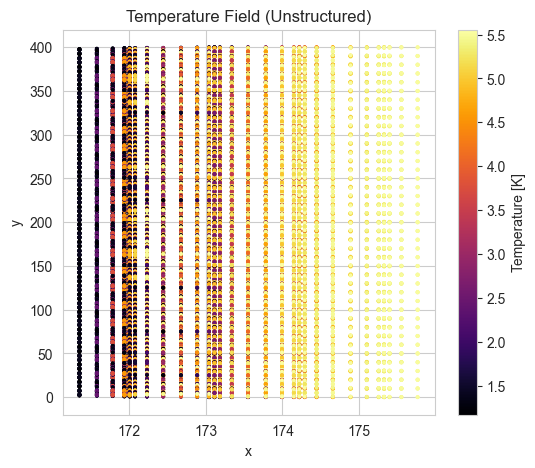

In [15]:
plt.figure(figsize=(6, 5))
plt.scatter(front["x"], front["y"], c=front["T"], cmap="inferno", s=3)
plt.colorbar(label="Temperature [K]")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Temperature Field (Unstructured)")
plt.show()

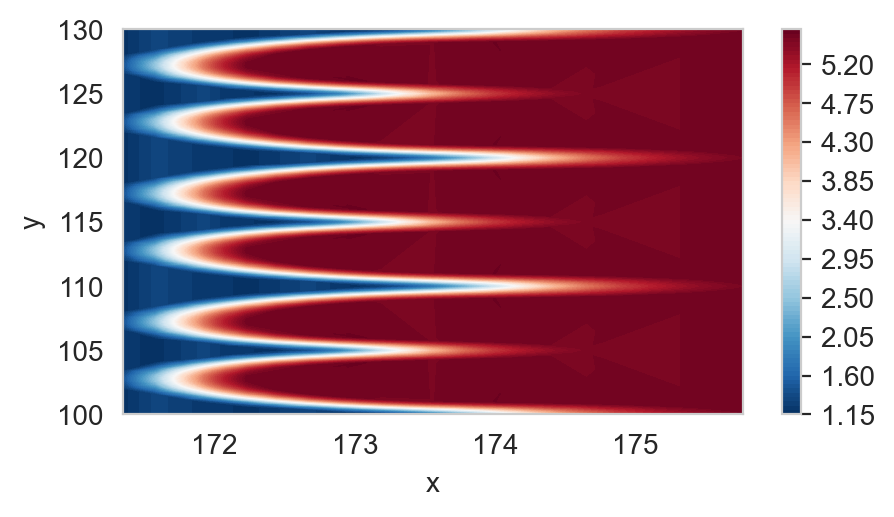

In [16]:
fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
c = ax.tricontourf(front["x"], front["y"] , front["T"], levels=100, cmap="RdBu_r")
fig.colorbar(c)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_ylim(100, 130)
plt.show()